In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class UpDownUpHomoTrimer(specifications.CoiledCoil):
    """Specification for creating up-down-up, homotrimeric coiled coils."""
    
    oligomeric_state = 3
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 3 helices, we have 3 values for each of these, but in this case they
        # are the same as we're making a homotrimer
        self.aas = [helix_length, helix_length, helix_length]
        self.major_radii = [radius, radius, radius]
        self.major_pitches = [pitch, pitch, pitch]
        #self.z_shifts = [0, zshift, zshift]
        self.phi_c_alphas = [phica, phica, phica]
        
        # We need to set the orientation of the helices
        self.orientations = [1, -1, 1] # up-down-up specification

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [12]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 6.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27)
]

In [13]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 6.0, 200, 154.2]


### Genetic Algorithm

In [14]:
opt_ga = ev_opts.GA(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	68   	-1324.88	67.7374	-1467.59	-1190.69
1  	68   	-1387.97	44.686 	-1470.39	-1308.34
2  	71   	-1429.4 	18.1764	-1470.9 	-1399.55
3  	73   	-1446.29	14.2309	-1470.9 	-1422.64
4  	75   	-1459.67	7.51509	-1471.21	-1442.35
5  	64   	-1465.43	4.48977	-1471.87	-1457.67
6  	74   	-1468.72	2.5162 	-1473.41	-1462.32
7  	68   	-1470.76	0.956972	-1474.31	-1469.12
8  	71   	-1471.65	1.05209 	-1474.52	-1470.39
9  	68   	-1472.38	1.2032  	-1474.92	-1470.85
10 	54   	-1473.34	1.15635 	-1475.14	-1471.25
11 	72   	-1474.38	0.450793	-1475.23	-1473.4 
12 	74   	-1474.75	0.274998	-1475.3 	-1474.23
13 	70   	-1474.93	0.167371	-1475.44	-1474.6 
14 	73   	-1475.02	0.129529	-1475.44	-1474.81
15 	78   	-1475.07	0.113157	-1475.44	-1474.92
16 	59   	-1475.13	0.127285	-1475.44	-1474.97
17 	65   	-1475.19	0.135972	-1475.44	-1475.01
18 	74   	-1475.27	0.137815	-1475.45	-1475.07
19 	76   	-1475.39	0.0882708	-1475.45	-1475.19
20 	77   	-1475.45	0.00292351	-1475.45	-1

In [16]:
optimized_model_ga = opt_ga.best_model

In [17]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-1476.0109888203003

In [18]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [19]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

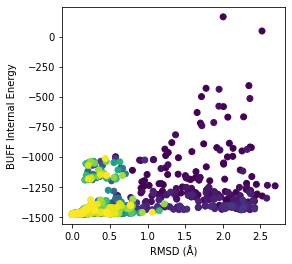

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [21]:
f = open('d_CC-Di_trimer_up_down_up-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [22]:
opt_de = ev_opts.DE(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [23]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg    	std   	min     	max     
0  	100  	-1248.1	153.84	-1416.81	-537.151
1  	100  	-1318.11	94.2985	-1436.31	-944.251
2  	100  	-1371.42	52.8052	-1471.5 	-1176.14
3  	100  	-1397.18	36.8412	-1471.5 	-1285.74
4  	100  	-1417.17	22.3431	-1471.5 	-1350.9 
5  	100  	-1428.77	17.3431	-1471.5 	-1389.08
6  	100  	-1434.99	15.4977	-1471.5 	-1397.77
7  	100  	-1443.23	14.3539	-1471.5 	-1403.4 
8  	100  	-1448.75	14.0195	-1471.78	-1409.67
9  	100  	-1454.28	11.3735	-1471.78	-1416.85
10 	100  	-1458.84	9.4514 	-1472.31	-1431.38
11 	100  	-1462.75	7.26706	-1472.31	-1437.14
12 	100  	-1465.7 	4.90909	-1472.31	-1440.6 
13 	100  	-1467.83	2.86246	-1472.62	-1459.26
14 	100  	-1468.72	2.57333	-1473.88	-1459.26
15 	100  	-1469.82	2.21443	-1475.25	-1463.27
16 	100  	-1470.39	1.93878	-1475.25	-1463.27
17 	100  	-1471.05	1.6078 	-1475.25	-1466.83
18 	100  	-1471.5 	1.40465	-1475.25	-1467.6 
19 	100  	-1471.99	1.37232	-1475.25	-1468.77
20 	100  	-1472.46	1.29112	-1475.28	-1469.08
21 	100  	-147

In [24]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-1476.191365785162

In [25]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [26]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

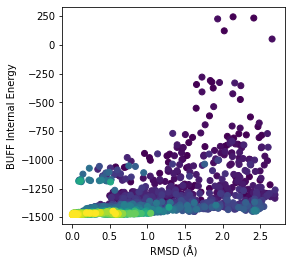

In [27]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [28]:
f = open('d_CC-Di_trimer_up_down_up-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [29]:
opt_pso = ev_opts.PSO(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [30]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-1238.96	195.285	-1465.31	-302.985
1  	68   	-1334.5 	142.048	-1468.07	-760.304
2  	49   	-1321.16	135.799	-1473.98	-920.05 
3  	66   	-1306.53	140.991	-1468.99	-906.074
4  	83   	-1252.9 	146.92 	-1445.1 	-871.647
5  	76   	-1354.77	142.814	-1462.29	-354.592
6  	54   	-1222.04	197.977	-1468.05	-354.592
7  	83   	-1209.99	171.681	-1432.29	-398.195
8  	84   	-1300.86	141.902	-1464.97	-847.07 
9  	55   	-1312.02	127.139	-1466.44	-935.052
10 	62   	-1165.83	260.324	-1429.96	98.3221 
11 	82   	-1240.2 	172.49 	-1460.66	-294.788
12 	72   	-1333.4 	108.349	-1465.96	-896.07 
13 	43   	-1278.82	160.232	-1457.51	-862.048
14 	64   	-1265.02	162.496	-1439.35	-718.974
15 	79   	-1273.96	176.022	-1464.21	-436.511
16 	75   	-1320.44	141.893	-1468.61	-854.889
17 	71   	-1289.64	162.444	-1462.86	-860.774
18 	70   	-1294.08	142.109	-1457.68	-899.572
19 	84   	-1299.22	147.669	-1457.76	-852.068
20 	75   	-1322.62	130.243	-1462.98	-901.627
21 	71   	

In [31]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-1473.9777940771048

In [32]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [33]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

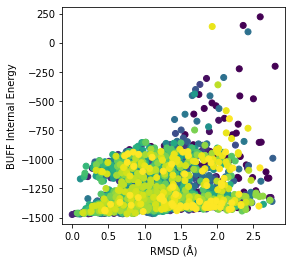

In [34]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [35]:
f = open('d_CC-Di_trimer_up_down_up-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [36]:
opt_cmaes = ev_opts.CMAES(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [37]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-1122.85	147.227	-1374.92	-594.879
1  	100  	-1145.85	228.497	-1436.45	276.056 
2  	100  	-1266.17	173.372	-1452.92	-638.49 
3  	100  	-1360.55	100.649	-1456.9 	-953.427
4  	100  	-1405.53	52.1277	-1465.68	-1038.41
5  	100  	-1367.8 	127.122	-1466.16	-1014.68
6  	100  	-1392.94	100.495	-1469.21	-1053.14
7  	100  	-1437.74	50.5977	-1471.42	-1049.62
8  	100  	-1450.35	43.7062	-1472.56	-1146.59
9  	100  	-1455.08	33.6701	-1474.71	-1151.33
10 	100  	-1466.92	4.56642	-1474.75	-1448.45
11 	100  	-1469.74	3.61647	-1475.15	-1460.44
12 	100  	-1469.95	4.77814	-1475.51	-1446.87
13 	100  	-1472.46	2.40977	-1475.69	-1461.56
14 	100  	-1474.11	1.35878	-1475.89	-1467   
15 	100  	-1474.76	1.43882	-1475.85	-1465.68
16 	100  	-1474.98	1.23495	-1476.05	-1465.85
17 	100  	-1474.86	1.79523	-1476.21	-1465.92
18 	100  	-1473.89	3.18659	-1476.16	-1462.37
19 	100  	-1475.42	1.76827	-1476.3 	-1466.51
20 	100  	-1475.75	0.992647	-1476.27	-1468.83
21 	100  

In [38]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-1476.4861337381383

In [39]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [40]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

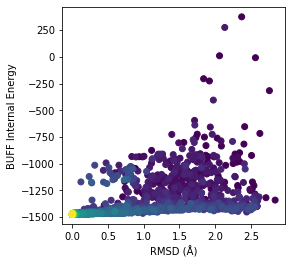

In [41]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [42]:
f = open('d_CC-Di_trimer_up_down_up-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)